The goal of this notebook is to determine the optimal combinations of models to use in `merge_horse_identities.py`

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.set_option('display.max_rows', None)

In [97]:
test_results = ['similarity_superpoint.csv',
                'similarity_aliked.csv',
                'similarity_disk.csv',
                'similarity_sift.csv',
                'similarity_deepfeatures.csv',
                'similarity_superpoint+DeepFeatures.csv', 
                'similarity_all.csv',
                'similarity_all_except_deepfeatures.csv',
                ]
ground_truth = 'similarity_groundtruth.csv'

In [98]:
def load_and_prepare_data_notebook(ground_truth_filepath, model_result_filepaths):
    """
    Loads ground truth and model prediction CSVs, merges them, and prepares for plotting.
    - Creates a 'pair_id' from 'canonical_id_a' and 'canonical_id_b'.
    - Converts 'is_match' from ground truth to numeric 'ground_truth' (1/0).
    - Renames 'max_similarity' from model files to 'prediction_<model_name>'.
    """
    model_names = []
    # 1. Load Ground Truth
    try:
        df_ground_truth = pd.read_csv(ground_truth_filepath)
        # Create a unique ID for merging: string concatenation of sorted IDs
        # Ensures ("A", "B") and ("B", "A") map to the same pair_id "A-B"
        df_ground_truth['pair_id'] = df_ground_truth.apply(
            lambda row: "-".join(sorted(map(str, [row['canonical_id_a'], row['canonical_id_b']]))), axis=1
        )
        
        if 'is_match' not in df_ground_truth.columns:
            print(f"Error: 'is_match' column not found in ground truth file: {ground_truth_filepath}")
            return None, []
            
        df_ground_truth = df_ground_truth.rename(columns={'is_match': 'ground_truth'})
        # Convert boolean/object ground_truth to int (1 for True, 0 for False)
        # Handle potential string 'True'/'False' by converting to bool first
        if df_ground_truth['ground_truth'].dtype == 'object':
             df_ground_truth['ground_truth'] = df_ground_truth['ground_truth'].map({'True': 1, 'False': 0, True: 1, False: 0}).fillna(0).astype(int)
        else:
            df_ground_truth['ground_truth'] = df_ground_truth['ground_truth'].astype(bool).astype(int)
        
        base_df = df_ground_truth[['pair_id', 'ground_truth']].copy()
        base_df = base_df.drop_duplicates(subset=['pair_id'], keep='first') # Ensure unique pair_ids from ground truth

    except Exception as e:
        print(f"Error loading or processing ground truth file {ground_truth_filepath}: {e}")
        return None, []

    # 2. Load and Merge Model Predictions
    for file_path in model_result_filepaths:
        try:
            model_name_parts = os.path.basename(file_path).replace('similarity_', '').replace('.csv', '')
            model_name = "".join(c if c.isalnum() or c in ['_', '-', '+'] else '_' for c in model_name_parts)
            model_names.append(model_name)
            
            current_df = pd.read_csv(file_path)

            if not {'canonical_id_a', 'canonical_id_b', 'max_similarity'}.issubset(current_df.columns):
                print(f"Warning: File {file_path} is missing required columns. Skipping.")
                if model_name in model_names: model_names.remove(model_name)
                continue
            
            current_df['pair_id'] = current_df.apply(
                lambda row: "-".join(sorted(map(str, [row['canonical_id_a'], row['canonical_id_b']]))), axis=1
            )
            
            prediction_col_name = f'prediction_{model_name}'
            current_df = current_df.rename(columns={'max_similarity': prediction_col_name})
            
            current_model_df = current_df[['pair_id', prediction_col_name]].copy()
            current_model_df = current_model_df.drop_duplicates(subset=['pair_id'], keep='first')

            base_df = pd.merge(base_df, current_model_df, on='pair_id', how='inner') # Inner join keeps only pairs present in GT and current model

        except Exception as e:
            print(f"Error processing model file {file_path}: {e}")
            if model_name in model_names: model_names.remove(model_name)
            continue

    if base_df.empty or len(model_names) == 0:
        print("No data merged successfully or no models processed. Check file paths, contents, and IDs.")
        return None, []
        
    base_df = base_df.rename(columns={'pair_id': 'id'})
    # Filter out models that didn't result in any merged columns (e.g. if all pair_ids mismatched)
    valid_model_names = [name for name in model_names if f'prediction_{name}' in base_df.columns]

    return base_df, valid_model_names

In [99]:
merged_df, model_names = load_and_prepare_data_notebook(ground_truth, test_results)

if merged_df is not None:
    print(f"Successfully loaded and merged data for models: {model_names}")
    print(f"Shape of merged_df: {merged_df.shape}")
    display(merged_df.head())
    # Check for NaN values which might indicate merge issues or missing data
    print("\nNaN counts per column:")
    print(merged_df.isnull().sum())
else:
    print("Failed to load or merge data.")

Successfully loaded and merged data for models: ['superpoint', 'aliked', 'disk', 'sift', 'deepfeatures', 'superpoint+DeepFeatures', 'all', 'all_except_deepfeatures']
Shape of merged_df: (68, 10)


,id,ground_truth,prediction_superpoint,prediction_aliked,prediction_disk,prediction_sift,prediction_deepfeatures,prediction_superpoint+DeepFeatures,prediction_all,prediction_all_except_deepfeatures
0,191-51,1,0.3398,0.0614,0.0607,0.1455,0.4983,0.3566,0.1571,0.1030
1,204-31,1,0.1468,0.1928,0.1070,0.0398,0.4674,0.2406,0.1130,0.0644
2,164-43,1,0.4078,0.0519,0.0412,0.0970,0.6381,0.4032,0.1766,0.1194
3,224-85,1,0.7846,0.0519,0.0680,0.4921,0.5956,0.6717,0.2812,0.2101
4,22-232,1,0.0367,0.0227,0.0264,0.0230,0.3478,0.1816,0.0848,0.0246



NaN counts per column:
id                                    0
ground_truth                          0
prediction_superpoint                 0
prediction_aliked                     0
prediction_disk                       0
prediction_sift                       0
prediction_deepfeatures               0
prediction_superpoint+DeepFeatures    0
prediction_all                        0
prediction_all_except_deepfeatures    0
dtype: int64


Generating Plot 1: Prediction vs. Ground Truth...


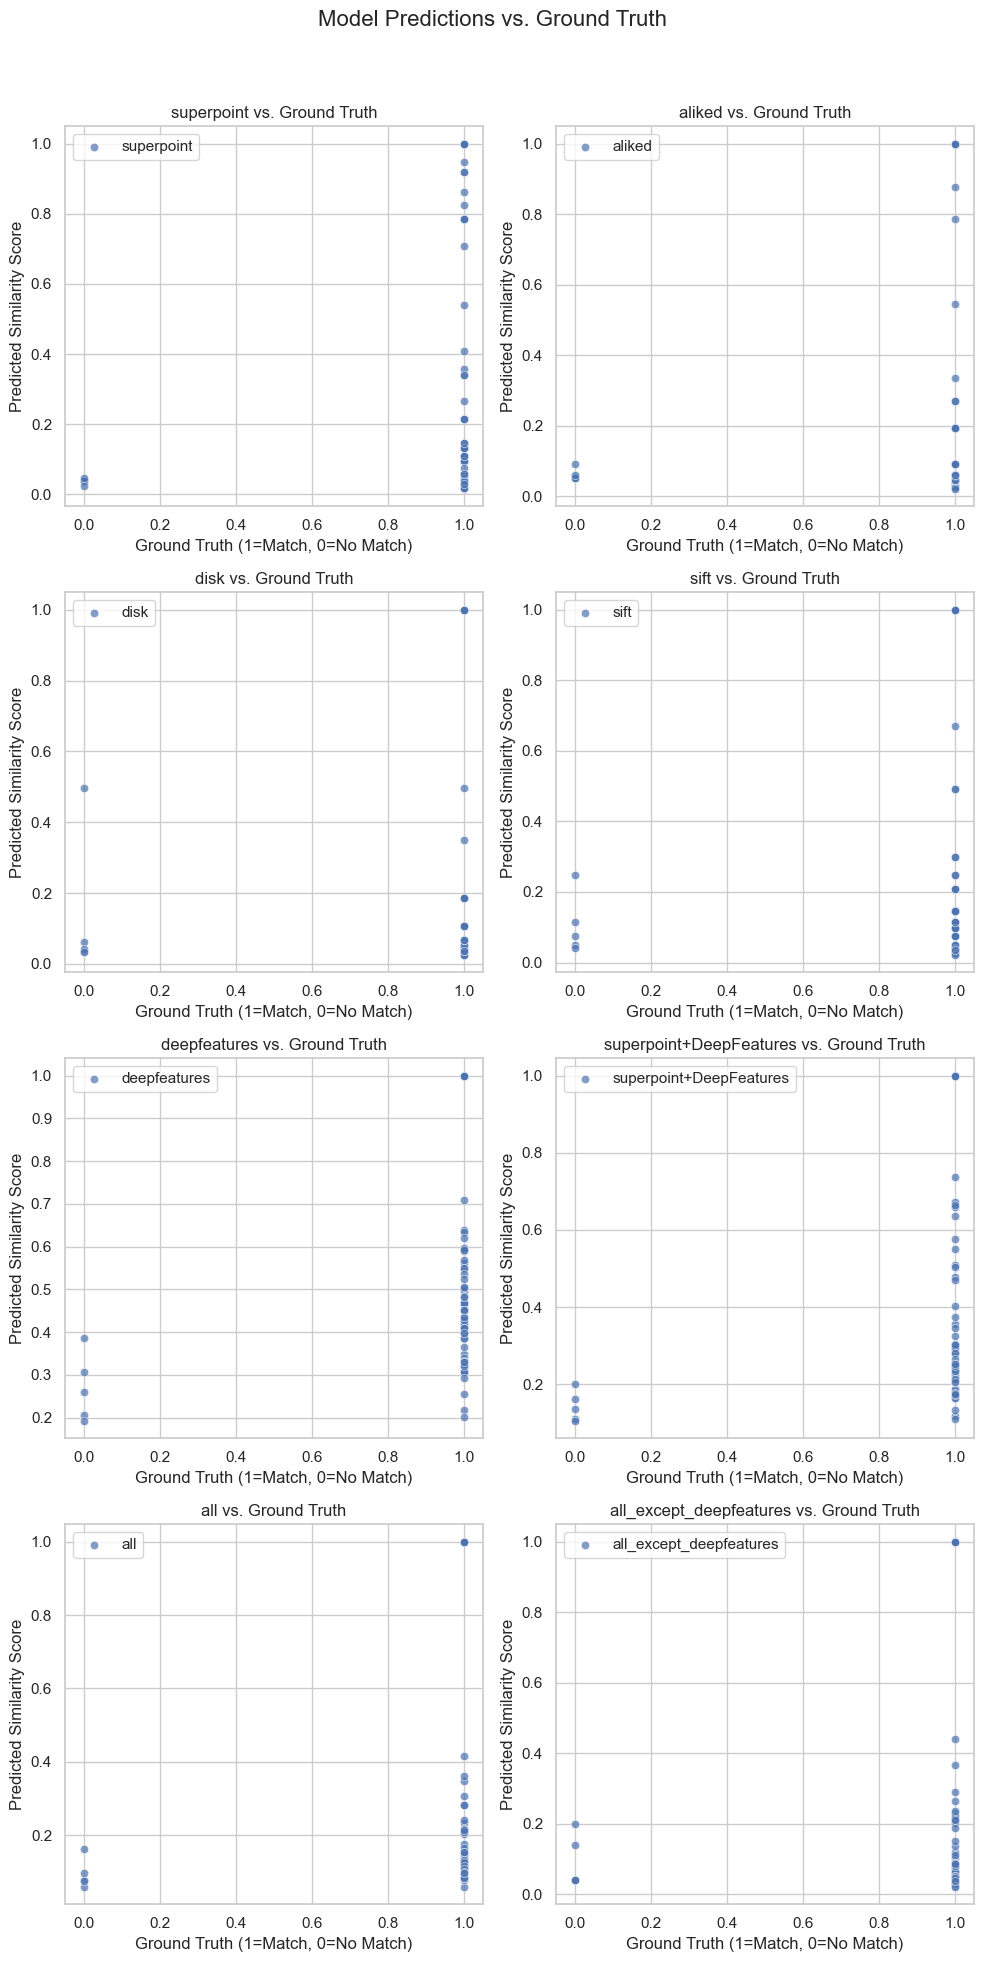

In [100]:
if merged_df is not None and model_names:
    sns.set_theme(style="whitegrid")
    print("Generating Plot 1: Prediction vs. Ground Truth...")
    num_models = len(model_names)
    cols = int(num_models**0.5) if num_models > 0 else 1
    rows = (num_models + cols - 1) // cols if num_models > 0 else 1
    
    fig1, axes1 = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), squeeze=False)
    axes1_flat = axes1.flatten()

    for i, model_name in enumerate(model_names):
        ax = axes1_flat[i]
        prediction_col = f'prediction_{model_name}'
        
        sns.scatterplot(x='ground_truth', y=prediction_col, data=merged_df, ax=ax, label=model_name, alpha=0.7)
        
        # For binary ground truth (0,1), a y=x line isn't as useful.
        # Instead, we can show distribution or just the scatter.
        # If ground_truth were continuous, this would be more relevant:
        # min_val = min(merged_df['ground_truth'].min(), merged_df[prediction_col].min())
        # max_val = max(merged_df['ground_truth'].max(), merged_df[prediction_col].max())
        # ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal (y=x)')
        
        ax.set_title(f'{model_name} vs. Ground Truth')
        ax.set_xlabel('Ground Truth (1=Match, 0=No Match)')
        ax.set_ylabel('Predicted Similarity Score')
        ax.legend()

    for j in range(i + 1, len(axes1_flat)): # Hide unused subplots
        fig1.delaxes(axes1_flat[j])

    fig1.suptitle('Model Predictions vs. Ground Truth', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Generating Plot 2: Comparative Predictions vs. Sample Index...


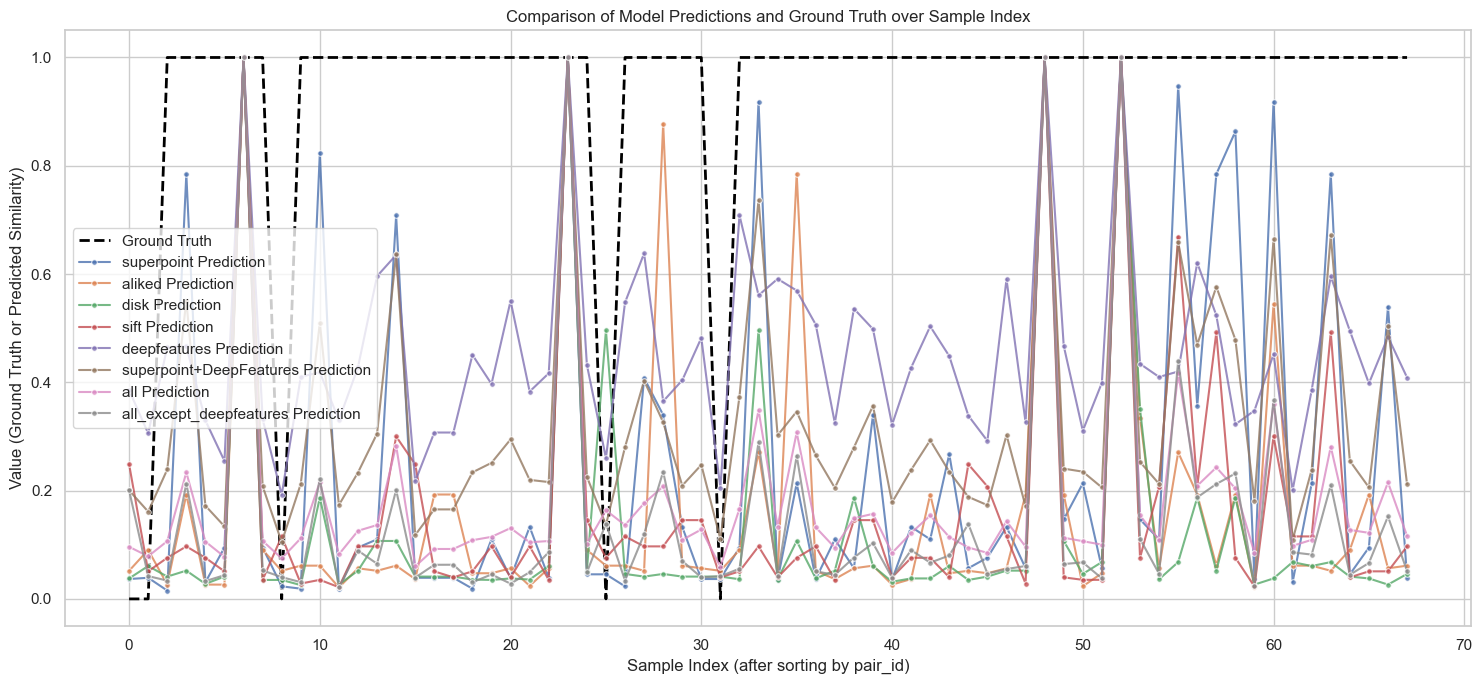

In [101]:
if merged_df is not None and model_names:
    print("Generating Plot 2: Comparative Predictions vs. Sample Index...")
    # Sort by 'id' (pair_id) if desired, then plot against integer index for clarity
    plot_df_sorted = merged_df.sort_values(by='id').reset_index(drop=True)
    
    plt.figure(figsize=(15, 7))
    sns.lineplot(x=plot_df_sorted.index, y='ground_truth', data=plot_df_sorted, label='Ground Truth', color='black', linewidth=2, linestyle='--')
    for model_name in model_names:
        prediction_col = f'prediction_{model_name}'
        sns.lineplot(x=plot_df_sorted.index, y=prediction_col, data=plot_df_sorted, label=f'{model_name} Prediction', marker='o', markersize=4, alpha=0.8)

    plt.title('Comparison of Model Predictions and Ground Truth over Sample Index')
    plt.xlabel('Sample Index (after sorting by pair_id)')
    plt.ylabel('Value (Ground Truth or Predicted Similarity)')
    plt.legend()
    plt.tight_layout()
    plt.show()

Generating Plot 3: Error Distribution...


/var/folders/hs/f1lmyqbj5m780x8vmm94m6v80000gn/T/ipykernel_7285/1251531808.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='error', data=error_df_long, palette="Set2")


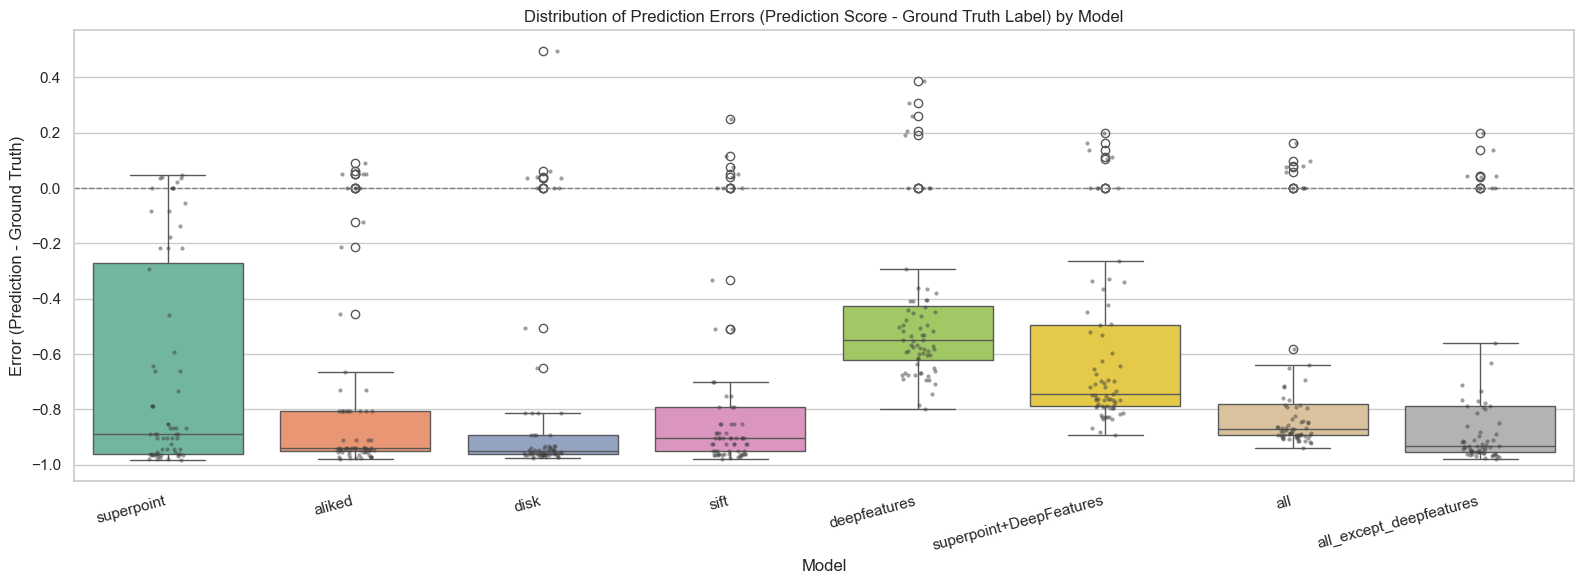

In [102]:
if merged_df is not None and model_names:
    print("Generating Plot 3: Error Distribution...")
    error_df_parts = []
    for model_name in model_names:
        prediction_col = f'prediction_{model_name}'
        # Error = Prediction - GroundTruth (Similarity Score - 0/1)
        # This error might be more meaningful if ground truth was also a score.
        # For binary GT, this shows how far predictions are from 0 or 1.
        error_values = merged_df[prediction_col] - merged_df['ground_truth']
        temp_df = pd.DataFrame({'error': error_values, 'model': model_name})
        error_df_parts.append(temp_df)

    if error_df_parts:
        error_df_long = pd.concat(error_df_parts)
        plt.figure(figsize=(max(10, 2 * len(model_names)), 6))
        sns.boxplot(x='model', y='error', data=error_df_long, palette="Set2")
        sns.stripplot(x='model', y='error', data=error_df_long, color=".25", size=3, alpha=0.5)
        plt.title('Distribution of Prediction Errors (Prediction Score - Ground Truth Label) by Model')
        plt.xlabel('Model')
        plt.ylabel('Error (Prediction - Ground Truth)')
        # Lines at 0 (perfect for non-matches predicted as 0) and 
        # potentially 1 (perfect for matches predicted as 1) or -1 (perfect for matches predicted as 0)
        # This error metric is a bit unusual for binary classification with score output.
        # A common error is (prediction_score - 1) for true matches and (prediction_score - 0) for true non-matches.
        # The current plot shows (prediction_score - GT_label).
        plt.axhline(0, color='grey', linestyle='--', linewidth=1) 
        plt.xticks(rotation=15, ha='right')
        plt.tight_layout()
        plt.show()

Generating Plot 4: Pairwise Model Predictions...


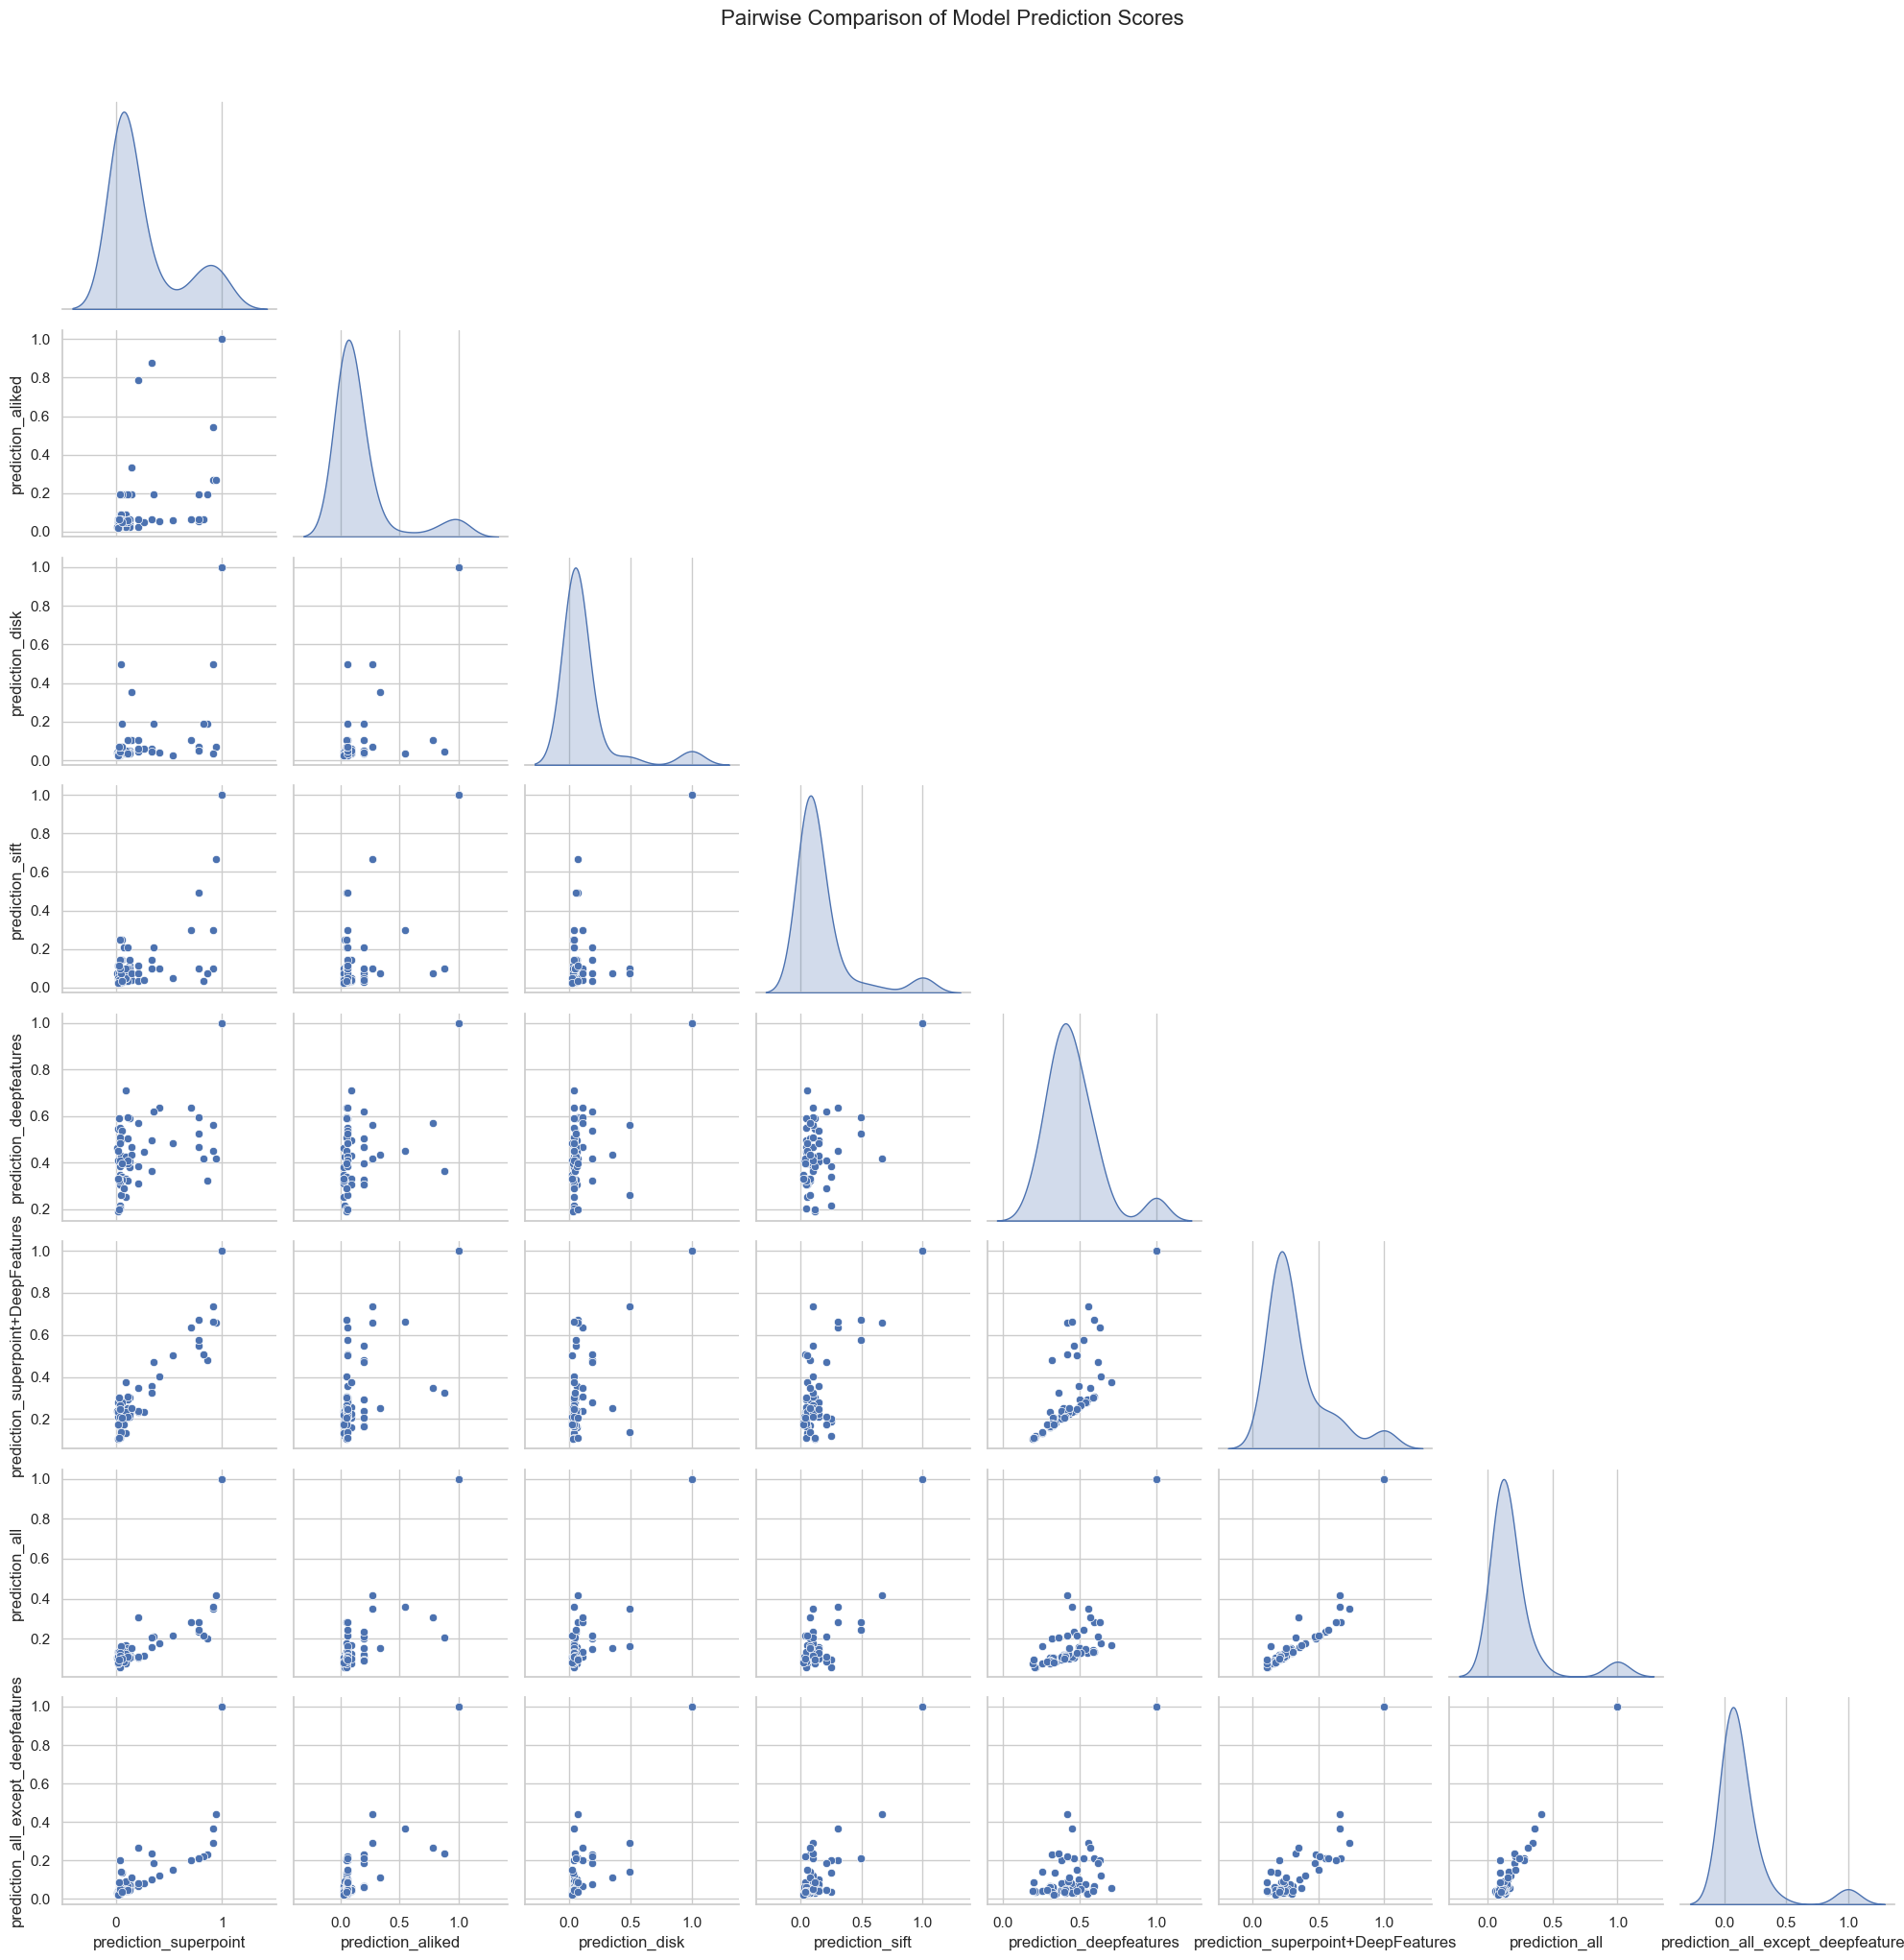

In [103]:
if merged_df is not None and len(model_names) > 1:
    print("Generating Plot 4: Pairwise Model Predictions...")
    prediction_cols_only = [f'prediction_{model}' for model in model_names]
    pair_plot_df = merged_df[prediction_cols_only]
    
    if not pair_plot_df.empty and pair_plot_df.shape[1] > 1:
        g = sns.pairplot(pair_plot_df, diag_kind='kde', corner=True)
        g.fig.suptitle('Pairwise Comparison of Model Prediction Scores', y=1.02, fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough models with prediction data for pairwise comparison.")
elif merged_df is not None:
    print("Skipping Plot 4: Only one model present or no models successfully processed.")

In [104]:
if merged_df is not None and model_names:
    results = []
    actual_positives_df = merged_df[merged_df['ground_truth'] == 1]
    actual_negatives_df = merged_df[merged_df['ground_truth'] == 0]

    if actual_negatives_df.empty:
        print("Warning: No actual non-matches (ground_truth = 0) found in the dataset.")
        print("The strategy to 'identify all False matches' is trivially met, but thresholds cannot be determined this way.")
        print("Consider a different strategy or ensure your dataset has non-matches.")
    else:
        total_actual_positives = len(actual_positives_df)
        total_actual_negatives = len(actual_negatives_df)

        for model_name in model_names:
            prediction_col = f'prediction_{model_name}'
            
            # Determine the threshold: max score for actual non-matches
            max_score_for_GT0 = actual_negatives_df[prediction_col].max()
            
            # If max_score_for_GT0 is NaN (e.g., all predictions for GT=0 are NaN), skip model or handle
            if pd.isna(max_score_for_GT0):
                print(f"Warning: Max score for non-matches is NaN for model {model_name}. Skipping.")
                results.append({
                    'Model': model_name,
                    'Threshold (Max Score for GT=0)': 'NaN',
                    'False Negatives (FN)': 'N/A',
                    'True Positives (TP)': 'N/A',
                    'False Positives (FP)': 'N/A', # By design would be 0 if threshold was valid
                    'True Negatives (TN)': 'N/A',
                    'Recall (Match Class)': 'N/A',
                    'Specificity (No-Match Class)': 'N/A'
                })
                continue

            threshold = max_score_for_GT0
            
            # Predictions based on this threshold
            # Predicted "match" (1) if score > threshold
            # Predicted "no match" (0) if score <= threshold
            
            # On actual positives:
            tp = (actual_positives_df[prediction_col] > threshold).sum()
            fn = (actual_positives_df[prediction_col] <= threshold).sum()
            
            # On actual negatives (by design of the threshold):
            tn = (actual_negatives_df[prediction_col] <= threshold).sum() # Should be all actual negatives
            fp = (actual_negatives_df[prediction_col] > threshold).sum()   # Should be 0
            
            recall = tp / total_actual_positives if total_actual_positives > 0 else 0
            specificity = tn / total_actual_negatives if total_actual_negatives > 0 else 0 # Should be 1.0

            results.append({
                'Model': model_name,
                'Threshold (Max Score for GT=0)': threshold,
                'False Negatives (FN)': fn,
                'True Positives (TP)': tp,
                'False Positives (FP)': fp,
                'True Negatives (TN)': tn,
                'Recall (Match Class)': recall,
                'Specificity (No-Match Class)': specificity
            })

        results_df = pd.DataFrame(results)
        
        print("\nModel Performance (with threshold set to Max Score of GT=0 cases):")
        display(results_df)

        if not results_df[results_df['False Negatives (FN)'] != 'N/A'].empty:
            # Sort by False Negatives (ascending), then by True Positives (descending) as a tie-breaker
            results_df_sorted = results_df[results_df['False Negatives (FN)'] != 'N/A'].sort_values(
                by=['False Negatives (FN)', 'True Positives (TP)'], 
                ascending=[True, False]
            )
            
            print("\nModels ranked by minimizing False Negatives (FN) then maximizing True Positives (TP):")
            display(results_df_sorted)
            
            best_model_row = results_df_sorted.iloc[0]
            print(f"\nRecommended Model: {best_model_row['Model']}")
            print(f"Recommended Threshold (score > {best_model_row['Threshold (Max Score for GT=0)']} for 'match'): {best_model_row['Threshold (Max Score for GT=0)']:.4f}")
            print(f"At this threshold:")
            print(f"  - False Positives (FP) for 'match' class: {best_model_row['False Positives (FP)']}")
            print(f"  - False Negatives (FN) for 'match' class: {best_model_row['False Negatives (FN)']}")
            print(f"  - True Positives (TP) for 'match' class: {best_model_row['True Positives (TP)']}")
            print(f"  - True Negatives (TN) for 'no-match' class: {best_model_row['True Negatives (TN)']}")
            print(f"  - Recall (Match Class): {best_model_row['Recall (Match Class)']:.4f}")
            print(f"  - Specificity (No-Match Class): {best_model_row['Specificity (No-Match Class)']:.4f}")
        else:
            print("\nCould not rank models as no valid FN/TP data was generated.")

else:
    print("merged_df is not available. Please run the data loading and preparation cell first.")




Model Performance (with threshold set to Max Score of GT=0 cases):


,Model,Threshold (Max Score for GT=0),False Negatives (FN),True Positives (TP),False Positives (FP),True Negatives (TN),Recall (Match Class),Specificity (No-Match Class)
0,superpoint,0.0454,20,43,0,5,0.682540,1.0
1,aliked,0.0905,44,19,0,5,0.301587,1.0
2,disk,0.4958,59,4,0,5,0.063492,1.0
3,sift,0.2486,54,9,0,5,0.142857,1.0
4,deepfeatures,0.3856,18,45,0,5,0.714286,1.0
5,superpoint+DeepFeatures,0.2005,12,51,0,5,0.809524,1.0
6,all,0.1636,44,19,0,5,0.301587,1.0
7,all_except_deepfeatures,0.2007,48,15,0,5,0.238095,1.0



Models ranked by minimizing False Negatives (FN) then maximizing True Positives (TP):


,Model,Threshold (Max Score for GT=0),False Negatives (FN),True Positives (TP),False Positives (FP),True Negatives (TN),Recall (Match Class),Specificity (No-Match Class)
5,superpoint+DeepFeatures,0.2005,12,51,0,5,0.809524,1.0
4,deepfeatures,0.3856,18,45,0,5,0.714286,1.0
0,superpoint,0.0454,20,43,0,5,0.682540,1.0
1,aliked,0.0905,44,19,0,5,0.301587,1.0
6,all,0.1636,44,19,0,5,0.301587,1.0
7,all_except_deepfeatures,0.2007,48,15,0,5,0.238095,1.0
3,sift,0.2486,54,9,0,5,0.142857,1.0
2,disk,0.4958,59,4,0,5,0.063492,1.0



Recommended Model: superpoint+DeepFeatures
Recommended Threshold (score > 0.2005 for 'match'): 0.2005
At this threshold:
  - False Positives (FP) for 'match' class: 0
  - False Negatives (FN) for 'match' class: 12
  - True Positives (TP) for 'match' class: 51
  - True Negatives (TN) for 'no-match' class: 5
  - Recall (Match Class): 0.8095
  - Specificity (No-Match Class): 1.0000


In [105]:
df = pd.read_csv('similarity_superpoint+DeepFeatures.csv')


In [106]:
df.columns

Index(['timestamp', 'name', 'canonical_id_a', 'canonical_id_b', 'message_id_a',
       'message_id_b', 'max_similarity', 'is_match'],
      dtype='object')

In [108]:
df[df.max_similarity >= .2005].sort_values(by='max_similarity')

,timestamp,name,canonical_id_a,canonical_id_b,message_id_a,message_id_b,max_similarity,is_match
20,2025-06-12 08:45:48,Guinness,1,166,197501aef3e81a5e,1973b897dd589eac,0.2005,False
17,2025-06-12 08:43:53,Glad,96,189,1974ff8564d05948,1973b81f71eb4594,0.2050,False
66,2025-06-12 12:52:11,Zar,34,208,1975009c52023d9f,1971c6cde1e05430,0.2058,False
18,2025-06-12 08:44:29,Griffin,87,229,1974ffad2bc0c306,1971c62f29fe4ef3,0.2059,False
12,2025-06-12 08:40:51,Fairwinds,118,217,1974fee544f3346b,1971c673a437ed97,0.2083,False
21,2025-06-12 09:10:02,Guinness,21,166,197500e274993eb8,1973b897dd589eac,0.2093,False
60,2025-06-12 12:48:24,Winnie,30,59,197500b41fe914ad,19750016cf536c39,0.2119,False
62,2025-06-12 12:49:37,Winnie,59,211,19750016cf536c39,1971c6c857702bbe,0.2124,False
43,2025-06-12 12:38:02,Remy,56,123,19750020ee22db8e,1973b9684885ab73,0.2124,False
28,2025-06-12 12:28:54,Mia,63,141,1975000a013b9b34,1973b90baf0fb548,0.2158,False
